## Imports


In [1]:
# imports
import os
import shutil
import random
import kaggle
import torch
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np


## Prepare data

In [2]:
# paths
tmp_path = 'tmp'
train_dataset_path = f'{tmp_path}/train_dataset'
test_dataset_path = f'{tmp_path}/test_dataset'


In [3]:
# download dataset
if not os.path.exists(train_dataset_path) or not os.path.exists(test_dataset_path):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('grassknoted/asl-alphabet', path=tmp_path, unzip=True)

    shutil.move(f"{tmp_path}/asl_alphabet_train/asl_alphabet_train", train_dataset_path)
    shutil.move(f"{tmp_path}/asl_alphabet_test/asl_alphabet_test", test_dataset_path)

    shutil.rmtree(f"{tmp_path}/asl_alphabet_train")
    shutil.rmtree(f"{tmp_path}/asl_alphabet_test")


## Configure PyTorch


In [4]:
# PyTorch device
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Prepare data


In [5]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform


Compose(
    Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [6]:
# Load dataset
dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
dataset


Dataset ImageFolder
    Number of datapoints: 87000
    Root location: tmp/train_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
# Get classes
classes = dataset.classes
classes


['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [8]:
# Count classes
classes_count = len(classes)
classes_count


29

In [9]:
# Set train/test split ratio
train_ratio = 0.8
test_ratio = 0.2
{"train_ratio": train_ratio, "test_ratio": test_ratio}


{'train_ratio': 0.8, 'test_ratio': 0.2}

In [10]:
# Set train/test sizes
train_size = int(train_ratio * len(dataset))
test_size = int(test_ratio * len(dataset))
{"train_size": train_size, "test_size": test_size}


{'train_size': 69600, 'test_size': 17400}

In [11]:
# Split dataset into train and test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [12]:
# Count train/test dataset sizes
train_dataset_count = len(train_dataset)
test_dataset_count = len(test_dataset)
{"train_dataset_count": train_dataset_count, "test_dataset_count": test_dataset_count}


{'train_dataset_count': 69600, 'test_dataset_count': 17400}

In [13]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


In [14]:
# Display random images function
def show_random_samples(dataset, classes, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 15))

    for i in range(num_samples):
        index = np.random.randint(0, len(dataset) - 1)
        image, label = dataset[index]

        axs[i].imshow(image.permute(1, 2, 0))
        axs[i].set_title(classes[label])
        axs[i].axis('off')

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


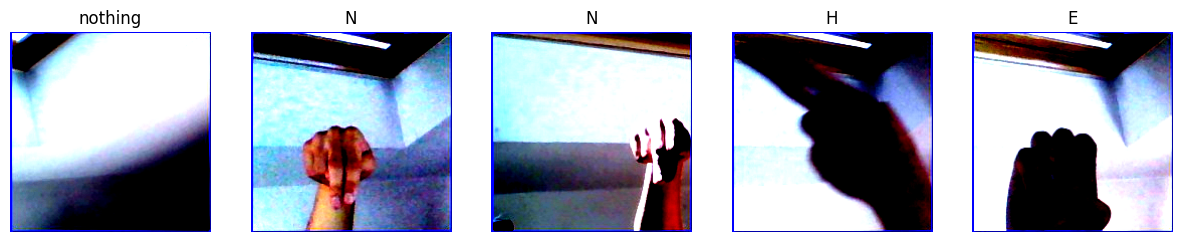

In [15]:
# Display random images from train dataset
show_random_samples(train_dataset, classes)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


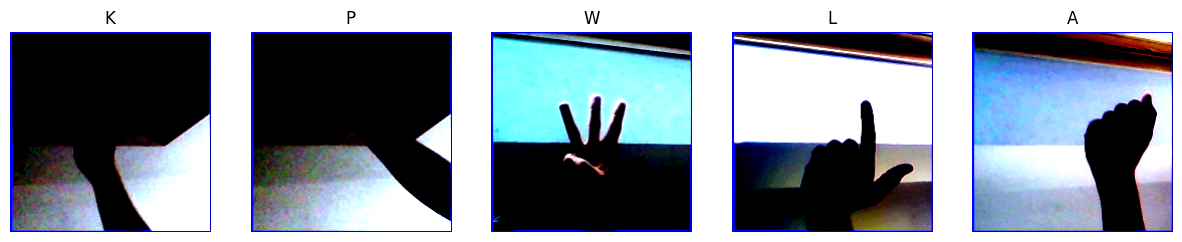

In [16]:
# Display random images from test dataset
show_random_samples(test_dataset, classes)


## Prepare models


### Make models folder

In [17]:
os.makedirs('tmp/models', exist_ok=True)


### AlexNet


In [18]:
AlexNet_model = models.alexnet()

# Freeze model parameters
for param in AlexNet_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
AlexNet_model.classifier[6] = torch.nn.Linear(AlexNet_model.classifier[6].in_features, classes_count)

# Move the model to the device (GPU if available)
AlexNet_model.to(device)

# Define loss function and optimizer
AlexNet_model_criterion = torch.nn.CrossEntropyLoss()
AlexNet_model_optimizer = torch.optim.Adam(AlexNet_model.parameters(), lr=0.001)


In [19]:
summary(AlexNet_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 49, 49]          23,296
              ReLU-2           [-1, 64, 49, 49]               0
         MaxPool2d-3           [-1, 64, 24, 24]               0
            Conv2d-4          [-1, 192, 24, 24]         307,392
              ReLU-5          [-1, 192, 24, 24]               0
         MaxPool2d-6          [-1, 192, 11, 11]               0
            Conv2d-7          [-1, 384, 11, 11]         663,936
              ReLU-8          [-1, 384, 11, 11]               0
            Conv2d-9          [-1, 256, 11, 11]         884,992
             ReLU-10          [-1, 256, 11, 11]               0
           Conv2d-11          [-1, 256, 11, 11]         590,080
             ReLU-12          [-1, 256, 11, 11]               0
        MaxPool2d-13            [-1, 256, 5, 5]               0
AdaptiveAvgPool2d-14            [-1, 25

### GoogleNet


In [20]:
GoogleNet_model = models.googlenet(models.GoogLeNet_Weights.DEFAULT)

# Freeze model parameters
for param in GoogleNet_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
GoogleNet_model.fc = torch.nn.Linear(GoogleNet_model.fc.in_features, classes_count)

# Move the model to the device (GPU if available)
GoogleNet_model.to(device)

# Define loss function and optimizer
GoogleNet_model_criterion = torch.nn.CrossEntropyLoss()
GoogleNet_model_optimizer = torch.optim.Adam(GoogleNet_model.parameters(), lr=0.001)


/home/rbrauner/data/workspace/studies/uekat-master-degree-studies-thesis/model/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [21]:
summary(GoogleNet_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
       BasicConv2d-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
       BasicConv2d-7           [-1, 64, 50, 50]               0
            Conv2d-8          [-1, 192, 50, 50]         110,592
       BatchNorm2d-9          [-1, 192, 50, 50]             384
      BasicConv2d-10          [-1, 192, 50, 50]               0
        MaxPool2d-11          [-1, 192, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          12,288
      BatchNorm2d-13           [-1, 64, 25, 25]             128
      BasicConv2d-14           [-1, 64,

### MobileNet V2


In [22]:
# MobileNetV2_model = models.MobileNetV2()

# # Freeze model parameters
# for param in MobileNetV2_model.parameters():
#     param.requires_grad = False

# # Modify the last fully connected layer to fit your number of classes
# MobileNetV2_model.classifier[6] = torch.nn.Linear(MobileNetV2_model.classifier[6].in_features, classes_count)

# # Move the model to the device (GPU if available)
# MobileNetV2_model.to(device)

# # Define loss function and optimizer
# MobileNetV2_model_criterion = torch.nn.CrossEntropyLoss()
# MobileNetV2_model_optimizer = torch.optim.Adam(MobileNetV2_model.parameters(), lr=0.001)


In [23]:
# summary(MobileNetV2_model, input_size=(3, 200, 200))


### MobileNet V3


In [24]:
# MobileNetV3_model = models.MobileNetV3()

# # Freeze model parameters
# for param in MobileNetV3_model.parameters():
#     param.requires_grad = False

# # Modify the last fully connected layer to fit your number of classes
# MobileNetV3_model.classifier[6] = torch.nn.Linear(MobileNetV3_model.classifier[6].in_features, classes_count)

# # Move the model to the device (GPU if available)
# MobileNetV3_model.to(device)

# # Define loss function and optimizer
# MobileNetV3_model_criterion = torch.nn.CrossEntropyLoss()
# MobileNetV3_model_optimizer = torch.optim.Adam(MobileNetV3_model.parameters(), lr=0.001)


In [25]:
# summary(MobileNetV3_model, input_size=(3, 200, 200))


### ResNet 18


In [26]:
ResNet18_model = models.resnet18()

# Freeze model parameters
for param in ResNet18_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
ResNet18_model.fc = torch.nn.Linear(ResNet18_model.fc.in_features, classes_count)

# Move the model to the device (GPU if available)
ResNet18_model.to(device)

# Define loss function and optimizer
ResNet18_model_criterion = torch.nn.CrossEntropyLoss()
ResNet18_model_optimizer = torch.optim.Adam(ResNet18_model.parameters(), lr=0.001)


In [27]:
summary(ResNet18_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]          36,864
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
       BasicBlock-11           [-1, 64, 50, 50]               0
           Conv2d-12           [-1, 64, 50, 50]          36,864
      BatchNorm2d-13           [-1, 64, 50, 50]             128
             ReLU-14           [-1, 64,

### ResNet 50


In [28]:
ResNet50_model = models.resnet50()

# Freeze model parameters
for param in ResNet50_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
ResNet50_model.fc = torch.nn.Linear(ResNet50_model.fc.in_features, classes_count)

# Move the model to the device (GPU if available)
ResNet50_model.to(device)

# Define loss function and optimizer
ResNet50_model_criterion = torch.nn.CrossEntropyLoss()
ResNet50_model_optimizer = torch.optim.Adam(ResNet50_model.parameters(), lr=0.001)


In [29]:
summary(ResNet50_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,408
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         MaxPool2d-4           [-1, 64, 50, 50]               0
            Conv2d-5           [-1, 64, 50, 50]           4,096
       BatchNorm2d-6           [-1, 64, 50, 50]             128
              ReLU-7           [-1, 64, 50, 50]               0
            Conv2d-8           [-1, 64, 50, 50]          36,864
       BatchNorm2d-9           [-1, 64, 50, 50]             128
             ReLU-10           [-1, 64, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]          16,384
      BatchNorm2d-12          [-1, 256, 50, 50]             512
           Conv2d-13          [-1, 256, 50, 50]          16,384
      BatchNorm2d-14          [-1, 256,

### Vgg16


In [30]:
Vgg16_model = models.vgg16()

# Freeze model parameters
for param in Vgg16_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
Vgg16_model.classifier[6] = torch.nn.Linear(Vgg16_model.classifier[6].in_features, classes_count)

# Move the model to the device (GPU if available)
Vgg16_model.to(device)

# Define loss function and optimizer
Vgg16_model_criterion = torch.nn.CrossEntropyLoss()
Vgg16_model_optimizer = torch.optim.Adam(Vgg16_model.parameters(), lr=0.001)


In [31]:
summary(Vgg16_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             ReLU-14          [-1, 256,

### Vgg19


In [32]:
Vgg19_model = models.vgg16()

# Freeze model parameters
for param in Vgg19_model.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to fit your number of classes
Vgg19_model.classifier[6] = torch.nn.Linear(Vgg19_model.classifier[6].in_features, classes_count)

# Move the model to the device (GPU if available)
Vgg19_model.to(device)

# Define loss function and optimizer
Vgg19_model_criterion = torch.nn.CrossEntropyLoss()
Vgg19_model_optimizer = torch.optim.Adam(Vgg19_model.parameters(), lr=0.001)


In [33]:
summary(Vgg19_model, input_size=(3, 200, 200))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
              ReLU-2         [-1, 64, 200, 200]               0
            Conv2d-3         [-1, 64, 200, 200]          36,928
              ReLU-4         [-1, 64, 200, 200]               0
         MaxPool2d-5         [-1, 64, 100, 100]               0
            Conv2d-6        [-1, 128, 100, 100]          73,856
              ReLU-7        [-1, 128, 100, 100]               0
            Conv2d-8        [-1, 128, 100, 100]         147,584
              ReLU-9        [-1, 128, 100, 100]               0
        MaxPool2d-10          [-1, 128, 50, 50]               0
           Conv2d-11          [-1, 256, 50, 50]         295,168
             ReLU-12          [-1, 256, 50, 50]               0
           Conv2d-13          [-1, 256, 50, 50]         590,080
             ReLU-14          [-1, 256,

### Custom


## Train models


In [34]:
# train model function
def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    epochs_losses = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)
        epoch_loss /= len(train_loader.dataset)
        epochs_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    return epochs_losses


### AlexNet


In [35]:
AlexNet_model_losses = None
model_path = 'tmp/models/ASL_AlexNet_model_V1.0.0.pth'
if not os.path.isfile(model_path):
    AlexNet_model_losses = train_model(AlexNet_model, train_loader, AlexNet_model_criterion, AlexNet_model_optimizer, device, num_epochs=10)
    torch.save(AlexNet_model, model_path)


In [36]:
AlexNet_model_losses


### GoogleNet


In [37]:
GoogleNet_model_losses = None
model_path = 'tmp/models/ASL_GoogleNet_model_V1.0.0.pth'
if not os.path.isfile(model_path):
    GoogleNet_model_losses = train_model(GoogleNet_model, train_loader, GoogleNet_model_criterion, GoogleNet_model_optimizer, device, num_epochs=10)
    torch.save(GoogleNet_model, model_path)


Epoch 1/10, Loss: 0.7887
Epoch 2/10, Loss: 0.3346
Epoch 3/10, Loss: 0.2716
Epoch 4/10, Loss: 0.2418
Epoch 5/10, Loss: 0.2281
Epoch 6/10, Loss: 0.2199
Epoch 7/10, Loss: 0.2097
Epoch 8/10, Loss: 0.2076
Epoch 9/10, Loss: 0.2071
Epoch 10/10, Loss: 0.2032


In [38]:
GoogleNet_model_losses


[0.7887046380769247,
 0.334609848795266,
 0.27159187374272564,
 0.24179638713426974,
 0.2280856524767547,
 0.21994363016952043,
 0.20974680675686092,
 0.20758495983635558,
 0.20711293047743626,
 0.2032192534195452]

### MobileNet V2


In [39]:
# MobileNetV2_model_losses = None
# model_path = 'tmp/models/ASL_MobileNetV2_model_V1.0.0.pth'
# if not os.path.isfile(model_path):
#     MobileNetV2_model_losses = train_model(MobileNetV2_model, train_loader, MobileNetV2_model_criterion, MobileNetV2_model_optimizer, device, num_epochs=10)
#     torch.save(MobileNetV2_model, model_path)


In [40]:
# MobileNetV2_model_losses


### MobileNet V3


In [41]:
# MobileNetV3_model_losses = None
# model_path = 'tmp/models/ASL_MobileNetV3_model_V1.0.0.pth'
# if not os.path.isfile(model_path):
#     MobileNetV3_model_losses = train_model(MobileNetV3_model, train_loader, MobileNetV3_model_criterion, MobileNetV3_model_optimizer, device, num_epochs=10)
#     torch.save(MobileNetV3_model, model_path)


In [42]:
# MobileNetV3_model_losses


### ResNet 18


In [43]:
ResNet18_model_losses = None
model_path = 'tmp/models/ASL_ResNet18_model_V1.0.0.pth'
if not os.path.isfile(model_path):
    ResNet18_model_losses = train_model(ResNet18_model, train_loader, ResNet18_model_criterion, ResNet18_model_optimizer, device, num_epochs=10)
    torch.save(ResNet18_model, model_path)


Epoch 1/10, Loss: 3.0347
Epoch 2/10, Loss: 2.5770
Epoch 3/10, Loss: 2.3221
Epoch 4/10, Loss: 2.1462
Epoch 5/10, Loss: 2.0175
Epoch 6/10, Loss: 1.9111
Epoch 7/10, Loss: 1.8249
Epoch 8/10, Loss: 1.7549
Epoch 9/10, Loss: 1.6928
Epoch 10/10, Loss: 1.6424


In [44]:
ResNet18_model_losses


[3.034740604312941,
 2.577023634307686,
 2.3220820881854527,
 2.146176763677049,
 2.017534257296858,
 1.9110571382237578,
 1.8248619564648332,
 1.7549115291135065,
 1.6927954863405776,
 1.6423843296642961]

### ResNet 50


In [45]:
ResNet50_model_losses = None
model_path = 'tmp/models/ASL_ResNet50_model_V1.0.0.pth'
if not os.path.isfile(model_path):
    ResNet50_model_losses = train_model(ResNet50_model, train_loader, ResNet50_model_criterion, ResNet50_model_optimizer, device, num_epochs=10)
    torch.save(ResNet50_model, model_path)


Epoch 1/10, Loss: 3.3191
Epoch 2/10, Loss: 2.8488
Epoch 3/10, Loss: 2.5764
Epoch 4/10, Loss: 2.3911
Epoch 5/10, Loss: 2.2720
Epoch 6/10, Loss: 2.1613
Epoch 7/10, Loss: 2.0686
Epoch 8/10, Loss: 2.0153
Epoch 9/10, Loss: 1.9514
Epoch 10/10, Loss: 1.8894


In [46]:
ResNet50_model_losses


[3.319105865653904,
 2.848824164620761,
 2.576402214971082,
 2.3910808745197865,
 2.27195563519138,
 2.161288335076694,
 2.0685765414402404,
 2.0153474170312116,
 1.9513658291169966,
 1.8893818027123637]

### Vgg16


In [47]:
Vgg16_model_losses = None
model_path = 'tmp/models/ASL_Vgg16_model_V1.0.0.pth'
if not os.path.isfile(model_path):
    Vgg16_model_losses = train_model(Vgg16_model, train_loader, Vgg16_model_criterion, Vgg16_model_optimizer, device, num_epochs=10)
    torch.save(Vgg16_model, model_path)


Epoch 1/10, Loss: 3.2316
Epoch 2/10, Loss: 3.0909
Epoch 3/10, Loss: 3.0326
Epoch 4/10, Loss: 2.9958
Epoch 5/10, Loss: 2.9808
Epoch 6/10, Loss: 2.9671
Epoch 7/10, Loss: 2.9540
Epoch 8/10, Loss: 2.9468
Epoch 9/10, Loss: 2.9437
Epoch 10/10, Loss: 2.9305


In [48]:
Vgg16_model_losses


[3.231603964553482,
 3.090938189495569,
 3.032569994762026,
 2.995794025728072,
 2.980806115468343,
 2.967125301361084,
 2.9539952099460294,
 2.946781777129776,
 2.943691025766833,
 2.9304747605597834]

### Vgg19


In [49]:
Vgg19_model_losses = None
model_path = 'tmp/models/ASL_Vgg19_model_V1.0.0.pth'
if not os.path.isfile(model_path):
    Vgg19_model_losses = train_model(Vgg19_model, train_loader, Vgg19_model_criterion, Vgg19_model_optimizer, device, num_epochs=10)
    torch.save(Vgg19_model, model_path)


Epoch 1/10, Loss: 3.1951
Epoch 2/10, Loss: 3.0202
Epoch 3/10, Loss: 2.9411
Epoch 4/10, Loss: 2.9010
Epoch 5/10, Loss: 2.8707
Epoch 6/10, Loss: 2.8476
Epoch 7/10, Loss: 2.8382
Epoch 8/10, Loss: 2.8299
Epoch 9/10, Loss: 2.8160
Epoch 10/10, Loss: 2.8092


In [50]:
Vgg19_model_losses


[3.1951370685402005,
 3.0202219357983817,
 2.9410672218498144,
 2.9009702918173255,
 2.870699907609786,
 2.8476442846758614,
 2.8382101251887177,
 2.829893266305156,
 2.816025929067327,
 2.809221774901467]

### Custom


In [51]:
# Custom_model_losses = None
# model_path = 'tmp/models/ASL_Custom_model_V1.0.0.pth'
# if not os.path.isfile(model_path):
#     Custom_model_losses = train_model(Custom_model, train_loader, Custom_model_criterion, Custom_model_optimizer, device, num_epochs=10)
#     torch.save(Custom_model, model_path)


In [52]:
# Custom_model_losses


## Evaluate


### AlexNet


### GoogleNet


### MobileNet V2


### MobileNet V3


### ResNet 18


### ResNet 50


### Vgg16


### Vgg19


### Custom


## Test


### AlexNet


### GoogleNet


### MobileNet V2


### MobileNet V3


### ResNet 18


### ResNet 50


### Vgg16


### Vgg19


### Custom
